In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import seaborn as sns
import pandas as pd
import torch
# import pyro.distributions as dist
# from pyro.ops.tensor_utils import convolve
import torch.nn.functional as torch_F
import math
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
df_counts_time = pd.read_csv('./4days_date.csv', header = 0)
time = pd.to_datetime(df_counts_time['date'], format='%Y-%m-%d')

lineages = torch.load('./data/Omicron_experimental_data_new.pkl')['lineages']
country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']

counts = torch.load('./data/Omicron_experimental_data_new.pkl')['counts']
counts = counts / (counts.sum(-1).unsqueeze(-1))

counts1 = counts.numpy()
counts = np.nan_to_num(counts1)

In [4]:
def get_lineage_index(list):
    index = []
    for i in range(len(list)):
        index.append(lineages.index(list[i]))
    return index

In [5]:
## get counts & forecast data
def get_counts(country_index, lineage_index):
    df_counts = pd.DataFrame(counts[:, country_index, lineage_index])
    return df_counts

def get_forecast(country_index, lineage_index, forecast):
    df_forecast = pd.DataFrame(forecast[:, country_index, lineage_index].squeeze(1))
    return df_forecast

In [6]:
## get index of country
country_index1 = country.index('USA')
country_index2 = country.index('UnitedKingdom')
country_index3 = country.index('Germany')
country_index4 = country.index('France')
country_index5 = country.index('Brazil')
country_index6 = country.index('Poland')

## correlation between country sample & loss

In [7]:
counts = torch.load('./Omicron_experimental_data_new.pkl')['counts'][37:,:,:]
forecast_AE = torch.load('./10phase_AE.pkl', map_location=torch.device('cpu')).data.cpu()[:195,:,:][37:,:,:]

true = counts + 1e-20
count = true.sum(-1, True)
true_probs = true.data.cpu() / count.data.cpu()

def loss_cal(model): 
    pred = model

    # error = (pred - true_probs) * count**0.5  # scaled by Poisson stddev
    error = pred - true_probs 
    mae = error.abs().mean(0)  # average over time
    mse = error.square().mean(0)  # average over time

    return error, mae, mse

cal_MAE = loss_cal(forecast_AE)[1].sum(-1)
cal_MSE = loss_cal(forecast_AE)[2].sum(-1)
cal_count = counts.sum(-1).sum(0)

In [8]:
df = pd.DataFrame(columns=['country','log_sample','MAE','MSE'])
for i in range(len(country)):
    if cal_count[i].tolist() != 0:
        df.loc[len(df)] = [country[i],np.log(cal_count[i].tolist()),cal_MAE[i].tolist(),cal_MSE[i].tolist()]
df_sort = df.sort_values(by="log_sample",ascending=False)

In [406]:
pearsonr(df['log_sample'], df['MAE'])
# pearsonr(counts.sum(-1).sum(0), loss_cal(forecast_AE)[2].sum(-1))

PearsonRResult(statistic=-0.9348679016763203, pvalue=9.563231357672506e-89)

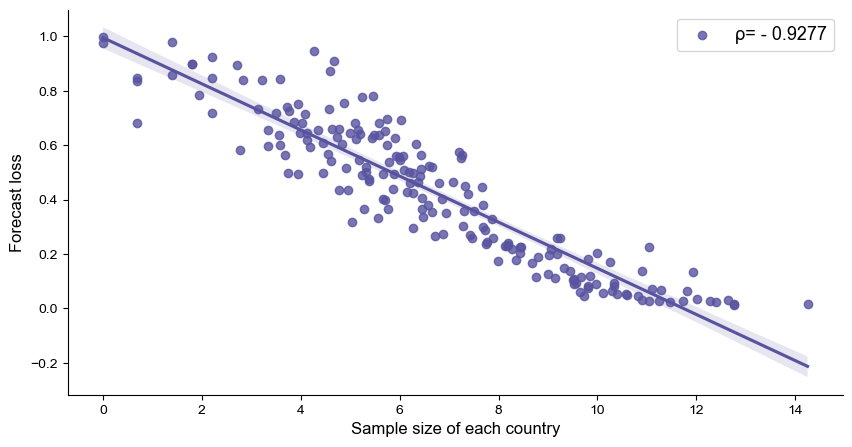

In [410]:
plt.figure(figsize=(10,5))
sns.regplot(x=df['log_sample'], y=df['MSE'], ci=95, label = chr(961) + '= - 0.9277', color = '#58539f')
plt.legend(fontsize = 13)
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)

plt.xlabel('Sample size of each country', fontsize = 12)
plt.ylabel('Forecast loss', fontsize = 12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Relationship between submissions and regularity and loss for countries at the same level of total loss - MAE

In [ ]:
def cal_loss(model): 
    pred = model[41:,:]

    # error = (pred - true_probs) * count**0.5  # scaled by Poisson stddev
    error = pred - true_probs[41:,:] 
    mae = error.abs().sum(-1)  # average over time
    mse = error.square().sum(-1)  # average over time

    return error, mae, mse

country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']
country_index_295_305 = []
country_index_245_255 = []
country_index_195_205 = []
country_index_145_155 = []
for i in range(len(country)):
    if cal_loss[i] > 295 and cal_loss[i] < 305:
        country_index_295_305.append(i)
    elif cal_loss[i] > 245 and cal_loss[i] < 255:
        country_index_245_255.append(i)
    elif cal_loss[i] > 195 and cal_loss[i] < 205:
        country_index_195_205.append(i)
    elif cal_loss[i] > 145 and cal_loss[i] < 155:
        country_index_145_155.append(i)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/2549713668.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_145_155[i]]+', size='+str(np.int(counts[m:n, country_index_145_155[i], :].sum())), fontsize = 12)


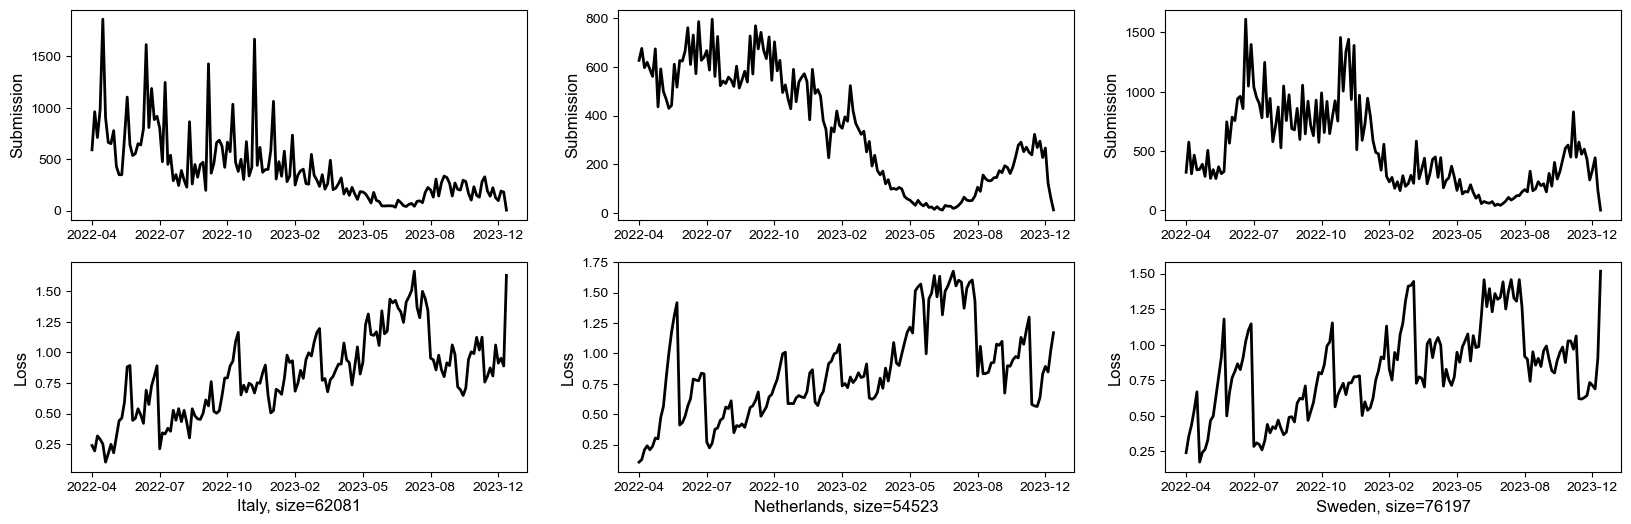

In [183]:
counts = torch.load('./data/Omicron_experimental_data_new.pkl')['counts']
counts1 = counts.numpy()
counts = np.nan_to_num(counts1)

def loss_cal_over_time(model): 
    pred = model
    error = pred - true_probs 
    mae = error.abs().sum(-1)
    mse = error.square().sum(-1)
    return error, mae, mse

### loss = 150
plt.figure(figsize=(20, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

datetime_plot = []
string_plot = []
for i in range(n-m):
        if i % 25 == 0:
            datetime_plot.append(time[m+i])
            string_plot.append(time[m+i].strftime('%Y-%m'))

for i in range(len(country_index_145_155)):
    plt.subplot(2,3,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_145_155[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.subplot(2,3,i+4)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index_145_155[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.xlabel(country[country_index_145_155[i]]+', size='+str(np.int(counts[m:n, country_index_145_155[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/3893597016.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_195_205[i]]+', size='+str(np.int(counts[m:n, country_index_195_205[i], :].sum())), fontsize = 12)


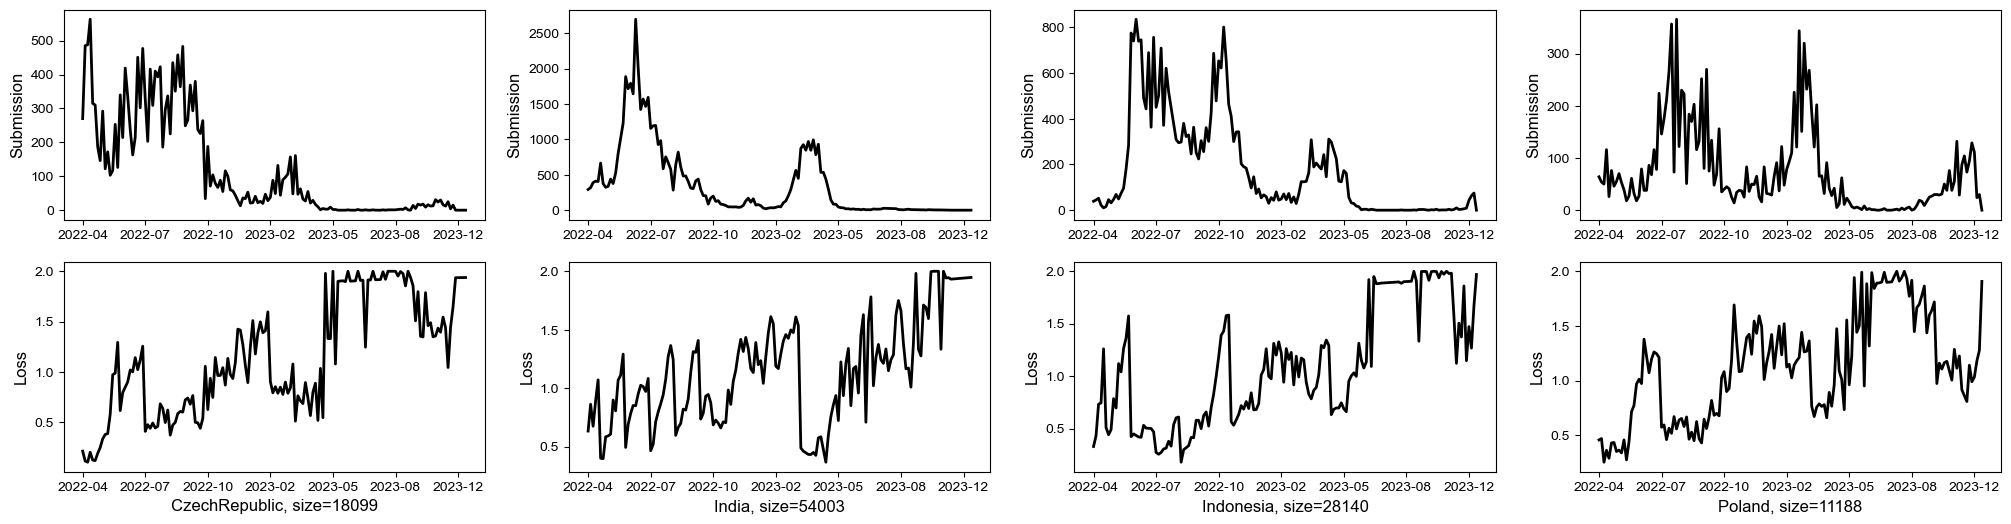

In [184]:
### loss = 200
plt.figure(figsize=(25, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_195_205)):
    plt.subplot(2,4,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_195_205[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.subplot(2,4,i+5)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index_195_205[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_195_205[i]]+', size='+str(np.int(counts[m:n, country_index_195_205[i], :].sum())), fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/1888229468.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_245_255[i]]+', size='+str(np.int(counts[m:n, country_index_245_255[i], :].sum())), fontsize = 12)


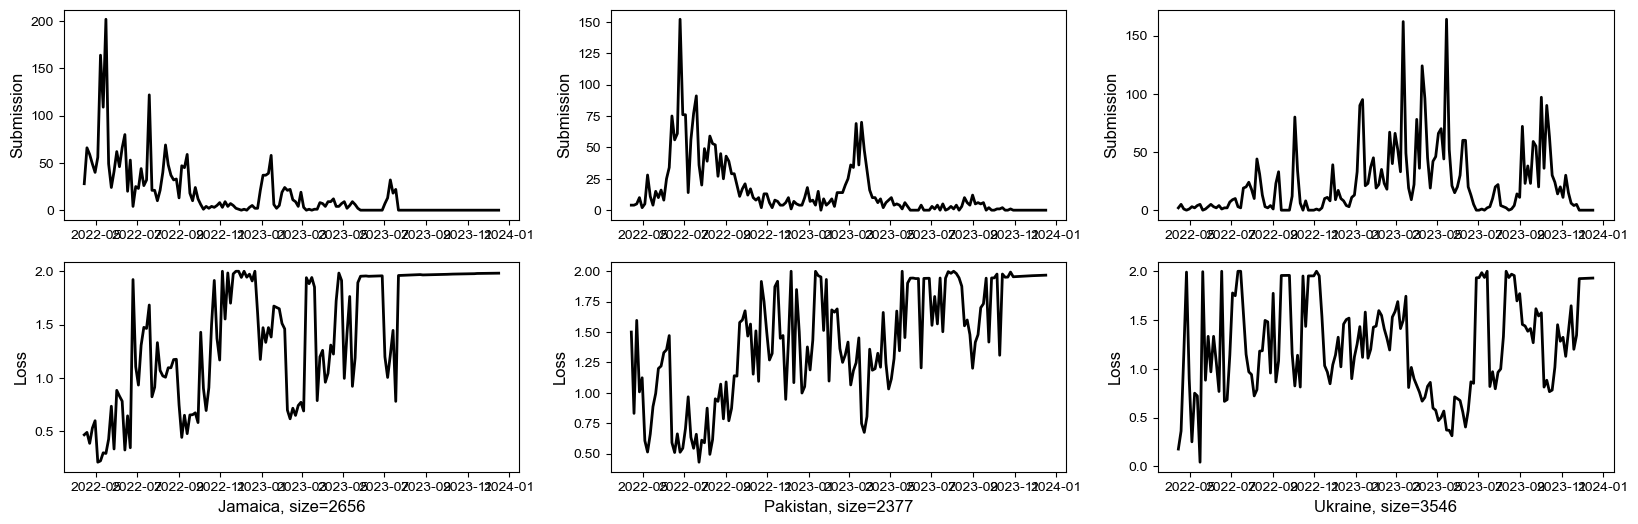

In [151]:
### loss = 250
plt.figure(figsize=(20, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_245_255)):
    plt.subplot(2,3,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_245_255[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.subplot(2,3,i+4)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index_245_255[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_245_255[i]]+', size='+str(np.int(counts[m:n, country_index_245_255[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/1822738522.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_295_305[i]]+', size='+str(np.int(counts[m:n, country_index_295_305[i], :].sum())), fontsize = 12)


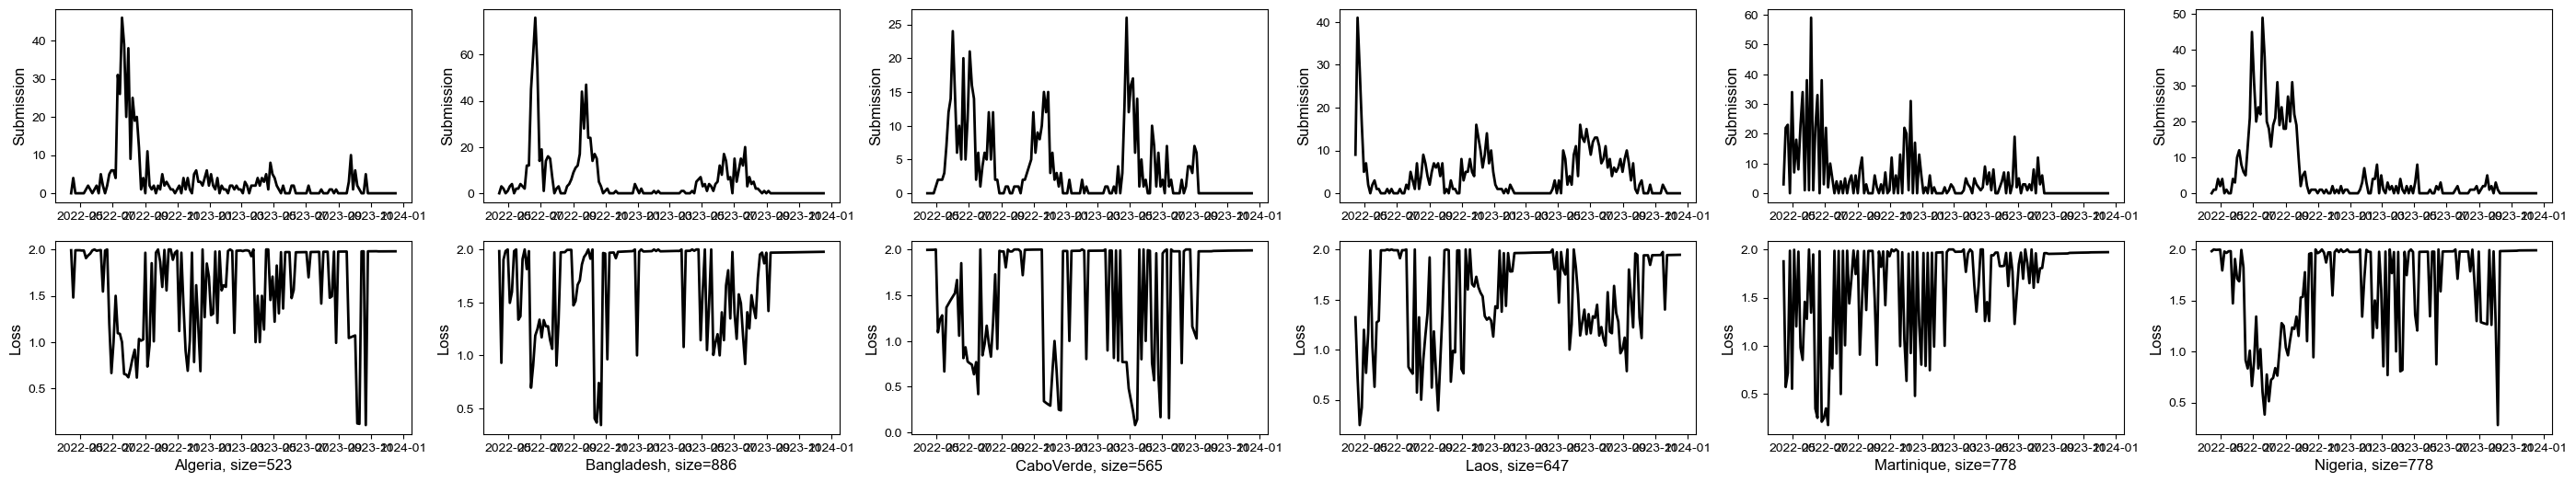

In [152]:
### loss = 300
plt.figure(figsize=(35, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_295_305)):
    plt.subplot(2,6,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_295_305[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.subplot(2,6,i+7)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index_295_305[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_295_305[i]]+', size='+str(np.int(counts[m:n, country_index_295_305[i], :].sum())), fontsize = 12)
plt.show()

### Relationship between submissions and regularity and loss for countries at the same level of total loss - MSE

In [174]:
country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']
country_index_6 = []
country_index_4 = []
country_index_2 = []
country_index_1 = []
for i in range(len(country)):
    if cal_loss[i] > 0.59 and cal_loss[i] < 0.61:
        country_index_6.append(i)
    elif cal_loss[i] > 0.39 and cal_loss[i] < 0.41:
        country_index_4.append(i)
    elif cal_loss[i] > 0.19 and cal_loss[i] < 0.21:
        country_index_2.append(i)
    elif cal_loss[i] > 0.09 and cal_loss[i] < 0.11:
        country_index_1.append(i)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/890269737.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_2[i]]+', size='+str(np.int(counts[m:n, country_index_2[i], :].sum())), fontsize = 12)


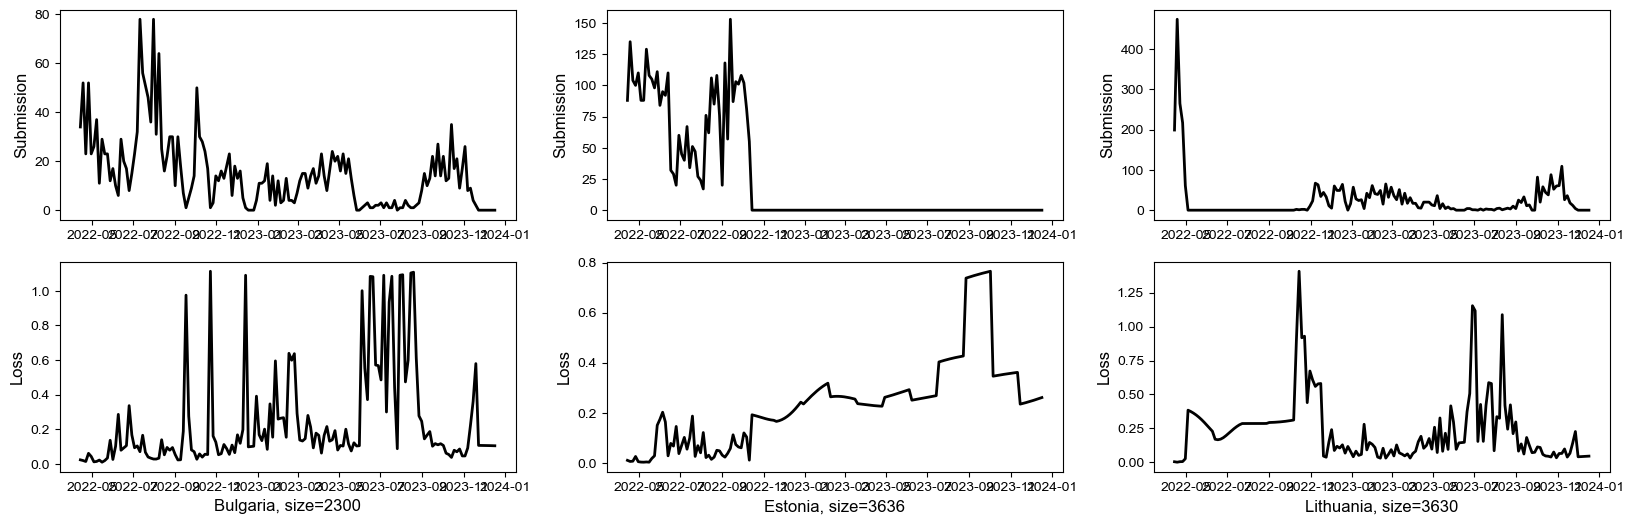

In [175]:
counts = torch.load('./data/Omicron_experimental_data_new.pkl')['counts']
counts1 = counts.numpy()
counts = np.nan_to_num(counts1)

def loss_cal_over_time(model): 
    pred = model
    error = pred - true_probs 
    mae = error.abs().sum(-1)
    mse = error.square().sum(-1)
    return error, mae, mse

### loss = 0.2
plt.figure(figsize=(20, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_2)):
    plt.subplot(2,3,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_2[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.subplot(2,3,i+4)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[2][m:n,country_index_2[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_2[i]]+', size='+str(np.int(counts[m:n, country_index_2[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/3998617661.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_4[i]]+', size='+str(np.int(counts[m:n, country_index_4[i], :].sum())), fontsize = 12)


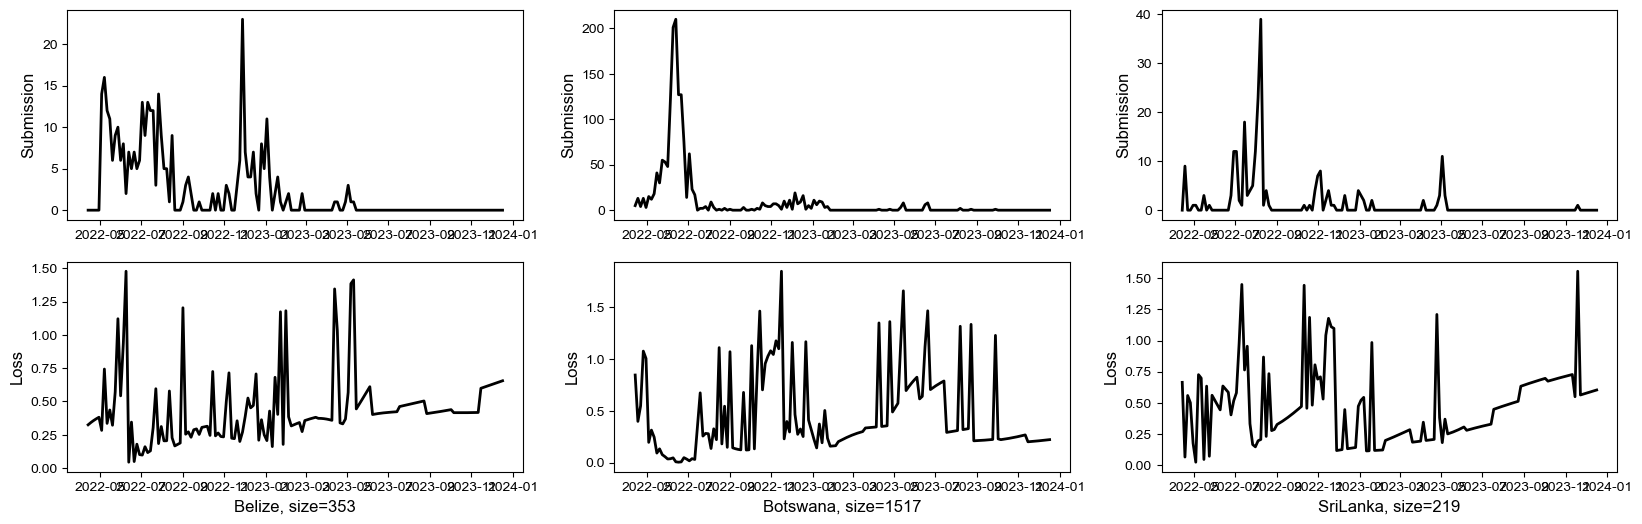

In [176]:
### loss = 0.4
plt.figure(figsize=(20, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_4)):
    plt.subplot(2,3,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_4[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.subplot(2,3,i+4)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[2][m:n,country_index_4[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_4[i]]+', size='+str(np.int(counts[m:n, country_index_4[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/128618527.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_6[i]]+', size='+str(np.int(counts[m:n, country_index_6[i], :].sum())), fontsize = 12)


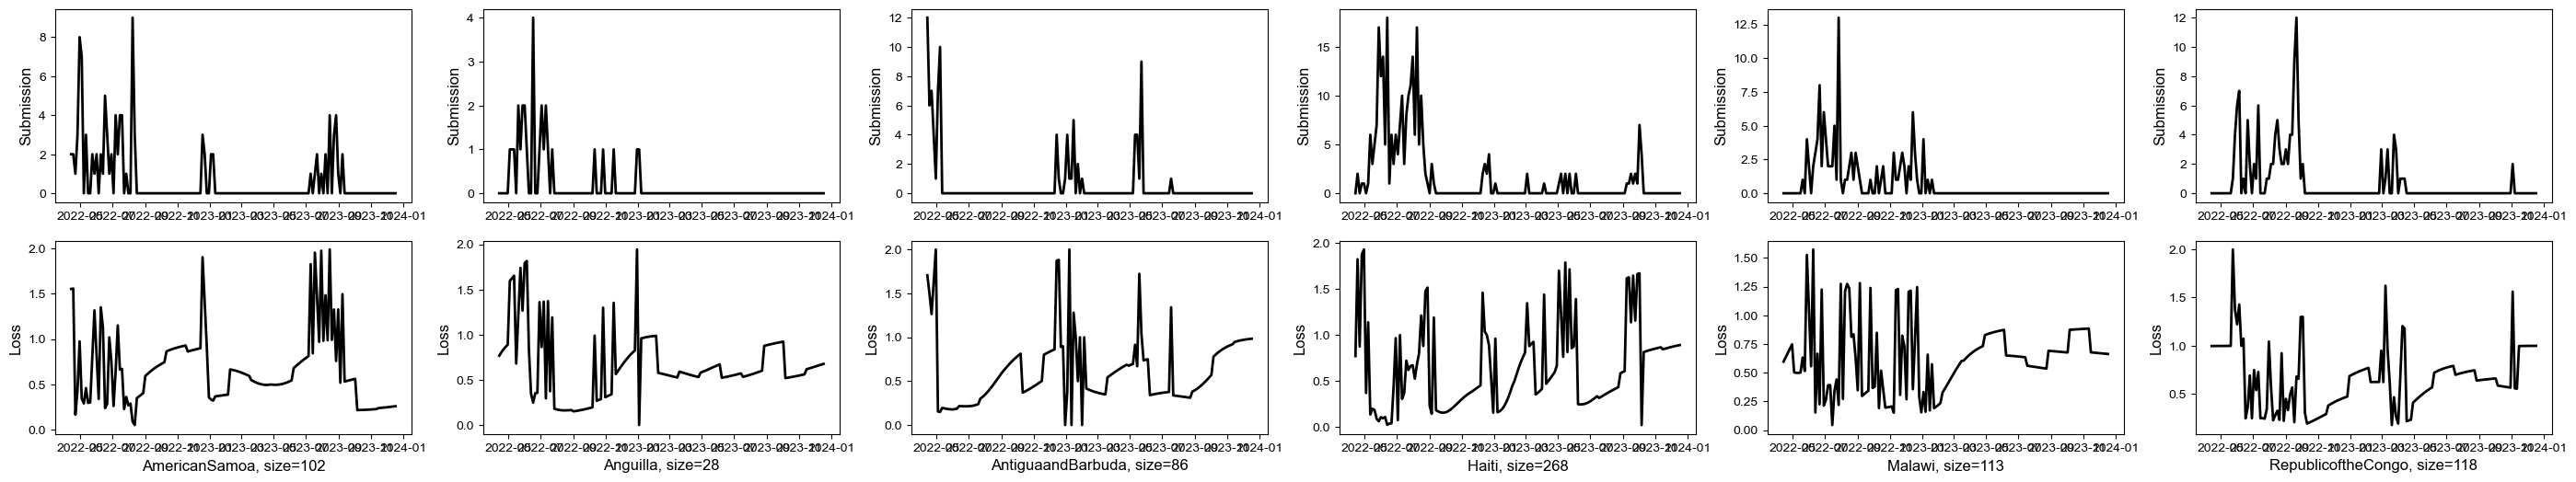

In [177]:
### loss = 0.6
plt.figure(figsize=(35, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_6)):
    plt.subplot(2,6,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_6[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.subplot(2,6,i+7)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[2][m:n,country_index_6[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_6[i]]+', size='+str(np.int(counts[m:n, country_index_6[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/215669696.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index_1[i]]+', size='+str(np.int(counts[m:n, country_index_1[i], :].sum())), fontsize = 12)


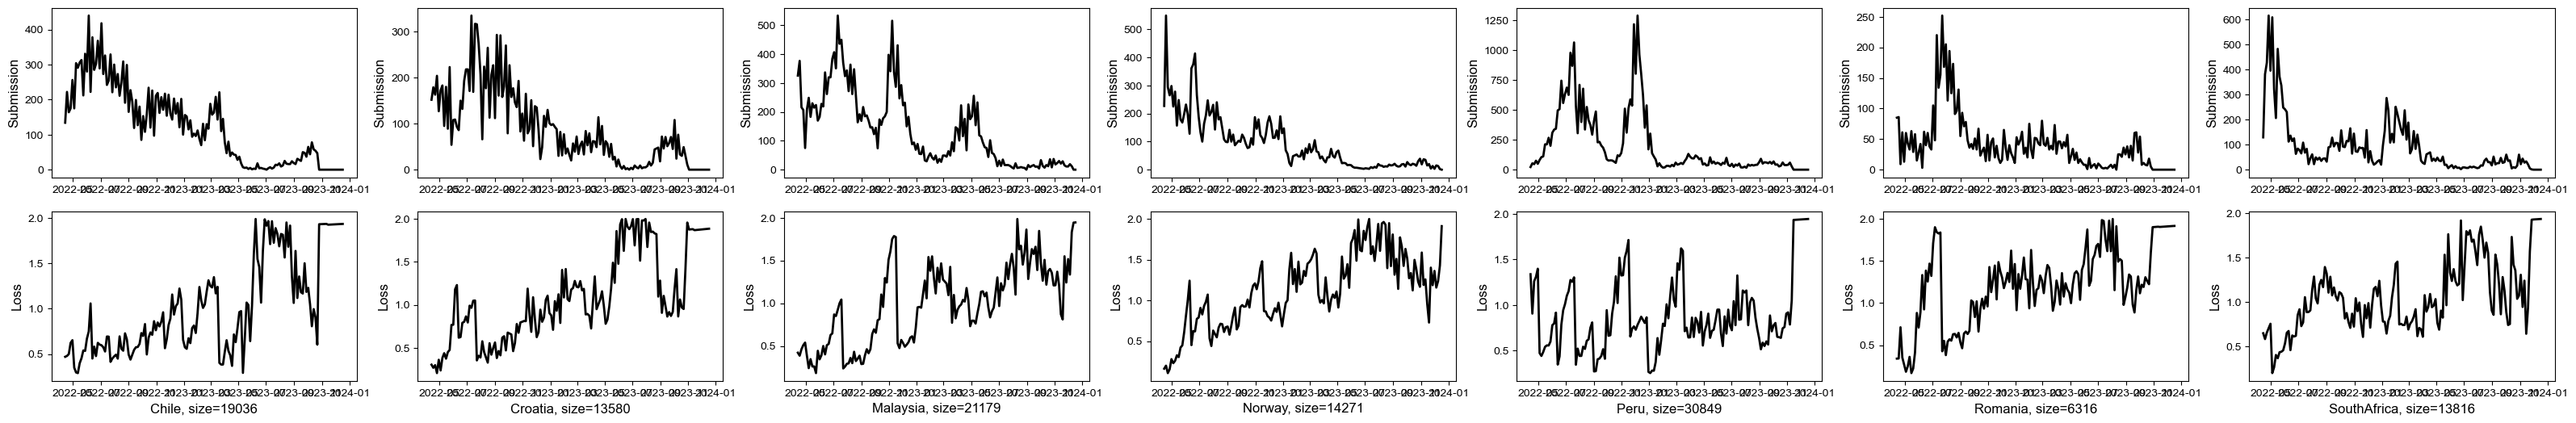

In [179]:
### loss = 0.1
plt.figure(figsize=(40, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

for i in range(len(country_index_1)):
    plt.subplot(2,7,i+1)
    plt.plot(time[m:n], counts[m:n, country_index_1[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.subplot(2,7,i+8)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index_1[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel(country[country_index_1[i]]+', size='+str(np.int(counts[m:n, country_index_1[i], :].sum())), fontsize = 12)
plt.show()

### country sample loss sort

In [29]:
counts = torch.load('./Omicron_experimental_data_new.pkl')['counts'][41:,:,:]
forecast_AE = torch.load('./data/10phase_AE_41_reparam.pkl', map_location=torch.device('cpu')).data.cpu()[:195,:,:][37:,:,:]
true = counts + 1e-20
count = true.sum(-1, True)
true_probs = true.data.cpu() / count.data.cpu()
def loss_cal(model): 
    pred = model

    # error = (pred - true_probs) * count**0.5  # scaled by Poisson stddev
    error = pred - true_probs 
    mae = error.abs().mean(0)  # average over time
    mse = error.square().mean(0)  # average over time

    return error, mae, mse
cal_MAE = loss_cal(forecast_AE)[1].sum(-1)
cal_MSE = loss_cal(forecast_AE)[2].sum(-1)
cal_count = counts.sum(-1).sum(0)
country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']

In [30]:
df = pd.DataFrame(columns=['country','sample','MAE', 'MSE','std','std_withoutLog'])
for i in range(len(country)):
    df.loc[len(df)] = [country[i],cal_count[i].tolist(),cal_MAE[i].tolist(),cal_MSE[i].tolist(),np.log10(np.std((counts[:,i,:].sum(-1)/counts[:,i,:].sum()*10000).tolist())), np.std((counts[:,i,:].sum(-1)/counts[:,i,:].sum()*10000).tolist())]
df_sort = df.sort_values(by="sample",ascending=False)
df1 = df.dropna(axis=0,how='any')

In [54]:
pearsonr(df1['MAE'], df1['std'])

PearsonRResult(statistic=0.8300794681581881, pvalue=2.3771038287367835e-51)

In [32]:
label_country1 = ['Austria', 'SouthKorea', 'Israel', 'Sweden']
label_country2 = ['China', 'Turkey', 'Pakistan']
label_plot1 = pd.DataFrame(columns=['country', 'country_index', 'count_log', 'MAE', 'MSE', 'std_log'])
label_plot2 = pd.DataFrame(columns=['country', 'country_index', 'count_log', 'MAE', 'MSE', 'std_log'])
for i in range(len(label_country1)):
    label_plot1.loc[len(label_plot1)] = [label_country1[i], country.index(label_country1[i]), cal_count[country.index(label_country1[i])], cal_MAE[country.index(label_country1[i])], cal_MSE[country.index(label_country1[i])], df['std'][country.index(label_country1[i])]]
for i in range(len(label_country2)):
    label_plot2.loc[len(label_plot2)] = [label_country2[i], country.index(label_country2[i]), cal_count[country.index(label_country2[i])], cal_MAE[country.index(label_country2[i])], cal_MSE[country.index(label_country2[i])], df['std'][country.index(label_country2[i])]]

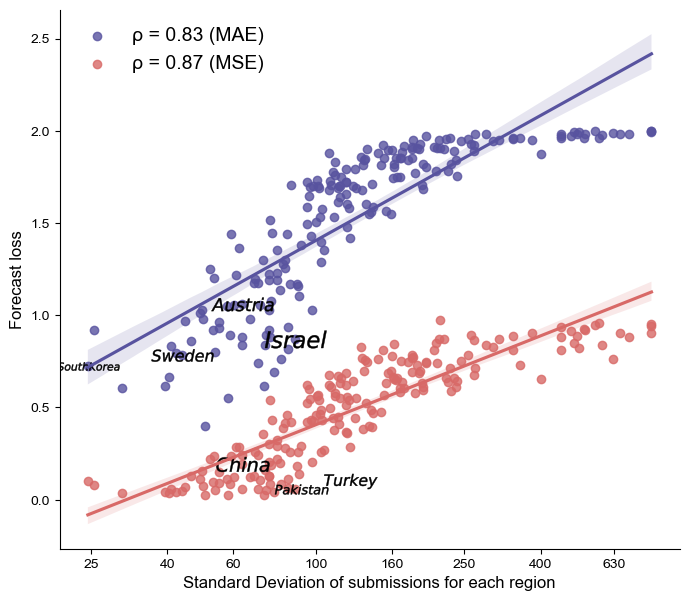

In [34]:
plt.figure(figsize=(8,7))
sns.regplot(x=df1['std'], y=df1['MAE'], ci=95, label = chr(961) + ' = 0.83 (MAE)', color = '#58539f')
sns.regplot(x=df1['std'], y=df1['MSE'], ci=95, label = chr(961) + ' = 0.87 (MSE)', color = '#d86967')
for i in range(len(label_plot1)):
    plt.scatter(label_plot1['std_log'][i], label_plot1['MAE'][i], s = 2000, c = 'black', marker = '$'+label_plot1['country'][i]+'$', lw = 0.3)
for i in range(len(label_plot2)):
    plt.scatter(label_plot2['std_log'][i], label_plot1['MSE'][i], s = 1500, c = 'black', marker = '$'+label_plot2['country'][i]+'$', lw = 0.3)

plt.legend(fontsize = 14, frameon=False)

plt.xlabel('Standard Deviation of submissions for each region', fontsize = 12)
plt.ylabel('Forecast loss', fontsize = 12)
# plt.xticks([1.4,1.6,1.8,2,2.2,2.4,2.6,2.8], [int(10**(1.4)),int(10**(1.6)),int(10**(1.8)),int(10**(2)),int(10**(2.2)),int(10**(2.4)),int(10**(2.6)),int(10**(2.8))], fontsize = 10)
plt.xticks([np.log10(25), np.log10(40), np.log10(60), np.log10(100), np.log10(160), np.log10(250), np.log10(400), np.log10(630)], [25, 40, 60, 100, 160, 250, 400, 630])
plt.yticks(fontsize = 10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [12]:
cal_num = []
for i in range(215):
    try:
        if df1['std'][i] > np.log10(160):
            cal_num.append(i)
    except:
        pass
len(cal_num)

69

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/3135478241.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt_sample.append(np.int(sample[i]))


[]

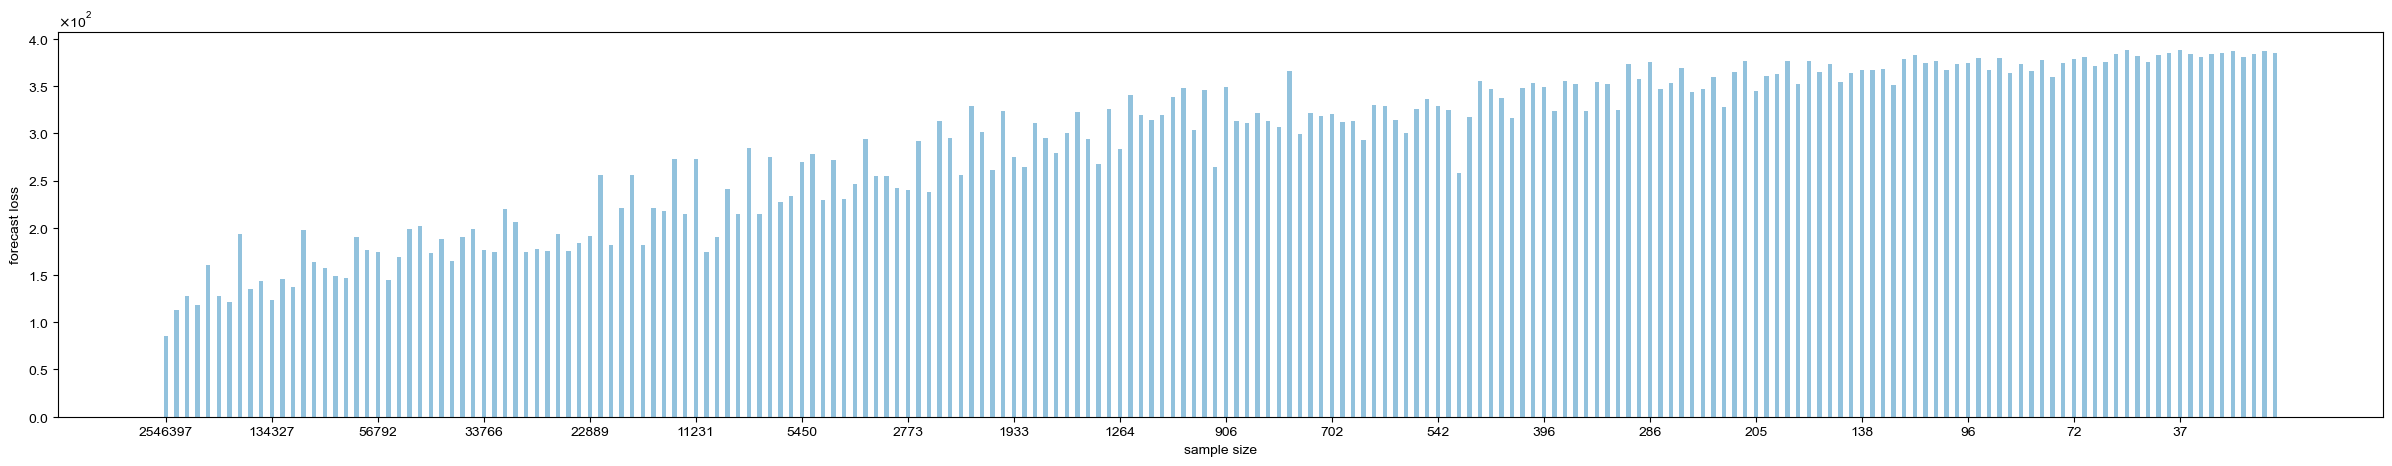

In [121]:
df_sort = pd.read_csv('/./sample_loss.csv',header=0)
x_label = df_sort['country'][0:200]
sample = df_sort['sample'][0:200]
loss = df_sort['loss'][0:200]

bar_width = 0.2
index_sigma_Eu = np.arange(len(sample))/2

fig=plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(111)
ax1.bar(index_sigma_Eu, height=loss, width=bar_width,color = '#92C2DD')

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt_x_site = []
plt_sample = []
for i in range(200):
    if i % 10 == 0:
        plt_x_site.append(index_sigma_Eu[i]+ bar_width/2 -0.1)
        plt_sample.append(np.int(sample[i]))
plt.xticks(plt_x_site, plt_sample, fontsize = 10)
plt.xlabel('sample size')
plt.ylabel('forecast loss')
plt.plot()

### loss & submission & std - Heatmap

In [45]:
counts = torch.load('./data/Omicron_experimental_data_new.pkl')['counts'][41:,:,:]
forecast_AE = torch.load('./10phase_AE.pkl', map_location=torch.device('cpu')).data.cpu()[:195,:,:][41:,:,:]
true = counts + 1e-20
count = true.sum(-1, True)
true_probs = true.data.cpu() / count.data.cpu()
def loss_cal(model): 
    pred = model

    # error = (pred - true_probs) * count**0.5  # scaled by Poisson stddev
    error = pred - true_probs 
    mae = error.abs().mean(0)  # average over time
    mse = error.square().mean(0)  # average over time

    return error, mae, mse
cal_MAE = loss_cal(forecast_AE)[1].sum(-1)
cal_MSE = loss_cal(forecast_AE)[2].sum(-1)
cal_count = counts.sum(-1).sum(0)
country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']

In [46]:
df = pd.DataFrame(columns=['country','sample','MAE', 'MSE','std'])
for i in range(len(country)):
    # df.loc[len(df)] = [country[i],np.log(cal_count[i].tolist()),cal_MAE[i].tolist(),cal_MSE[i].tolist(),np.log(np.std((counts[:,i,:].sum(-1)/counts[:,i,:].sum()*10000).tolist()))]
    df.loc[len(df)] = [country[i],cal_count[i].tolist(),cal_MAE[i].tolist(),cal_MSE[i].tolist(),np.std((counts[:,i,:].sum(-1)/counts[:,i,:].sum()*10000).tolist())]
df_sort = df.sort_values(by="sample",ascending=False)
df1 = df_sort.dropna(axis=0,how='any')

In [479]:
df1 = pd.read_csv('./size_std_loss2.csv', header=0)
# sample_sort = [-0.0001, 1.425, 2.85, 4.275, 5.7, 7.125, 8.55, 9.975, 11.4, 12.825, 14.25]  # log
# sample_sort = np.linspace(-0.000001,15,16) # log
sample_sort = [0.999,2,7,20,55,150,400,1100,3000,8100,22000,60000,163000,450000,1200000,3300000] # without log
# std_sort = [6.73, 6.23, 5.73, 5.23, 4.73, 4.23, 3.73, 3.23] # log
# std_sort = np.linspace(6.7, 3.2, 8) # log
std_sort = [820,500,300,180,110,65,40,25]

cal_num = torch.zeros(len(std_sort), len(sample_sort))
sum_loss_MAE = torch.zeros(len(std_sort), len(sample_sort))
sum_loss_MSE = torch.zeros(len(std_sort), len(sample_sort))

for i in range(len(df1)):
    for p in range(len(sample_sort)-1):
        if df1['sample'][i] > sample_sort[p] and df1['sample'][i] < sample_sort[p+1]:
            for q in range(len(std_sort)-1):
                if df1['std'][i] < std_sort[q] and df1['std'][i] > std_sort[q+1]:
                    cal_num[q, p] += 1
                    sum_loss_MAE[q, p] = sum_loss_MAE[q, p] + df1['MAE'][i]
                    sum_loss_MSE[q, p] = sum_loss_MSE[q, p] + df1['MSE'][i]
                    continue
            continue

In [289]:
MAE_heatmap = sum_loss_MAE / cal_num
MSE_heatmap = sum_loss_MSE / cal_num

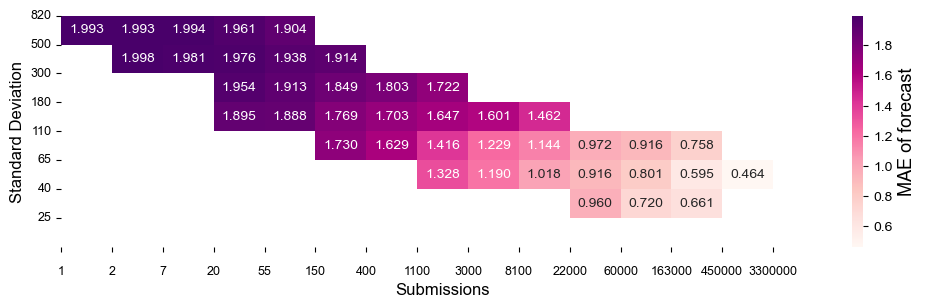

In [481]:
df_std = MAE_heatmap['std']
MAE_heatmap.drop('std', axis=1, inplace=True)
fig,ax1 = plt.subplots(figsize=(12,3))
plt.rcParams['font.sans-serif'] = ['Arial']

ax = sns.heatmap(MAE_heatmap, cmap = 'RdPu', cbar_kws={'label': 'MAE of forecast', 'pad':0.03},linewidths=0.002, annot=True, fmt='.3f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.collections[0].colorbar.ax.tick_params(labelsize=10)
ax.figure.axes[-1].yaxis.label.set_size(13)

# x_axis = pd.Series()
# for i in range(len(MAE_heatmap.keys())):
#     x_axis.loc[len(x_axis)] = int(np.e**(np.float(MAE_heatmap.keys()[i])))
x_axis = pd.Series([1,2,7,20,55,150,400,1100,3000,8100,22000,60000,163000,450000,3300000])
# y_axis = pd.Series()
# for i in range(len(df_std)):
#     y_axis.loc[len(y_axis)] = int(np.e**(df_std[i]))
y_axis = pd.Series([820,500,300,180,110,65,40,25])
plt.xticks(np.arange(0, len(MAE_heatmap.keys()), step = 1), x_axis[np.arange(0, len(MAE_heatmap.keys()), step = 1)],fontsize=9)
plt.yticks(np.arange(0, len(df_std), step = 1), y_axis[np.arange(0, len(df_std), step = 1)],fontsize=9)
plt.xlabel('Submissions', fontsize = 12)
plt.ylabel('Standard Deviation', fontsize = 12)
ax1.xaxis.set_tick_params(pad=10)
ax1.xaxis.set_tick_params(pad=10)

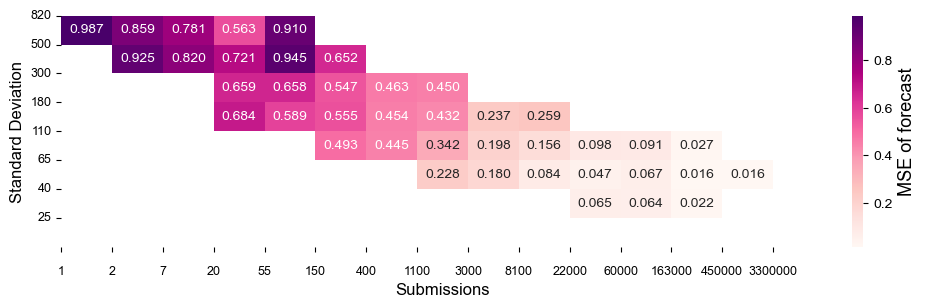

In [482]:
df_std = MSE_heatmap['std']
MSE_heatmap.drop('std', axis=1, inplace=True)
fig,ax1 = plt.subplots(figsize=(12,3))
plt.rcParams['font.sans-serif'] = ['Arial']

ax = sns.heatmap(MSE_heatmap, cmap = 'RdPu', cbar_kws={'label': 'MSE of forecast', 'pad':0.03},linewidths=0.002, annot=True, fmt='.3f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.collections[0].colorbar.ax.tick_params(labelsize=10)
ax.figure.axes[-1].yaxis.label.set_size(13)

# x_axis = pd.Series()
# for i in range(len(MAE_heatmap.keys())):
#     x_axis.loc[len(x_axis)] = int(np.e**(np.float(MAE_heatmap.keys()[i])))
x_axis = pd.Series([1,2,7,20,55,150,400,1100,3000,8100,22000,60000,163000,450000,3300000])
# y_axis = pd.Series()
# for i in range(len(df_std)):
#     y_axis.loc[len(y_axis)] = int(np.e**(df_std[i]))
y_axis = pd.Series([820,500,300,180,110,65,40,25])
plt.xticks(np.arange(0, len(MSE_heatmap.keys()), step = 1), x_axis[np.arange(0, len(MSE_heatmap.keys()), step = 1)],fontsize=9)
plt.yticks(np.arange(0, len(df_std), step = 1), y_axis[np.arange(0, len(df_std), step = 1)],fontsize=9)
plt.xlabel('Submissions', fontsize = 12)
plt.ylabel('Standard Deviation', fontsize = 12)
ax1.xaxis.set_tick_params(pad=10)
ax1.xaxis.set_tick_params(pad=10)

### Relationship between submission and regularity and loss for countries at the same SUBMISSION level

In [35]:
counts = torch.load('./data/Omicron_experimental_data_new.pkl')['counts']
forecast_AE = torch.load('/./10phase_AE_41_reparam.pkl', map_location=torch.device('cpu')).data.cpu()[:counts.shape[0],:,:]
country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']

true = counts + 1e-20
count = true.sum(-1, True)
true_probs = true / count

def loss_cal(model): 
    pred = model
    # error = (pred - true_probs) * count**0.5  # scaled by Poisson stddev
    error = pred - true_probs 
    mae = error.abs()#.mean(0)  # average over time
    mse = error.square()#.mean(0)  # average over time

    return error, mae, mse

In [36]:
cal_count = np.log10(counts.sum(-1).sum(0))
cal_MAE = loss_cal(forecast_AE)[1].sum(-1).mean(0)
cal_MSE = loss_cal(forecast_AE)[2].sum(-1).mean(0)
cal_count_withoutLog = counts.sum(-1).sum(0)

In [47]:
pearsonr(cal_count, cal_MAE)

PearsonRResult(statistic=-0.9323229270159684, pvalue=4.752109920713473e-96)

In [37]:
label_country1 = ['Austria', 'SouthKorea', 'Turkey', 'Pakistan']
label_country2 = ['Israel', 'Sweden', 'China']
label_plot1 = pd.DataFrame(columns=['country', 'country_index', 'count_log', 'MAE', 'MSE'])
label_plot2 = pd.DataFrame(columns=['country', 'country_index', 'count_log', 'MAE', 'MSE'])
for i in range(len(label_country1)):
    label_plot1.loc[len(label_plot1)] = [label_country1[i], country.index(label_country1[i]), cal_count[country.index(label_country1[i])], cal_MAE[country.index(label_country1[i])], cal_MSE[country.index(label_country1[i])]]
for i in range(len(label_country2)):
    label_plot2.loc[len(label_plot2)] = [label_country2[i], country.index(label_country2[i]), cal_count[country.index(label_country2[i])], cal_MAE[country.index(label_country2[i])], cal_MSE[country.index(label_country2[i])]]

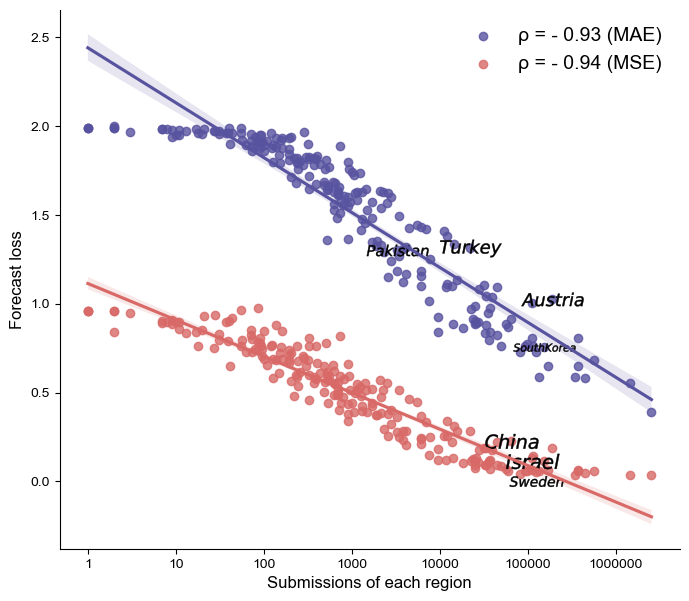

In [27]:
plt.figure(figsize=(8,7))
plt.rcParams['font.sans-serif'] = 'Arial'
sns.regplot(x=np.array(cal_count), y=np.array(cal_MAE), ci=95, label = chr(961) + ' = - 0.93 (MAE)', color = '#58539f')
sns.regplot(x=np.array(cal_count), y=np.array(cal_MSE), ci=95, label = chr(961) + ' = - 0.94 (MSE)', color = '#d86967')
for i in range(len(label_plot1)):
    plt.scatter(label_plot1['count_log'][i], label_plot1['MAE'][i], s = 2000, c = 'black', marker = '$'+label_plot1['country'][i]+'$', lw = 0.3)
for i in range(len(label_plot2)):
    if label_plot2['country'][i] == 'Israel':
        plt.scatter(label_plot2['count_log'][i], label_plot2['MSE'][i]+0.05, s = 1500, c = 'black', marker = '$'+label_plot2['country'][i]+'$',  lw = 0.3)
    elif label_plot2['country'][i] == 'Sweden':
        plt.scatter(label_plot2['count_log'][i], label_plot2['MSE'][i]-0.05, s = 1500, c = 'black', marker = '$'+label_plot2['country'][i]+'$',  lw = 0.3)
    elif label_plot2['country'][i] == 'Italy':
        plt.scatter(label_plot2['count_log'][i], label_plot2['MSE'][i]-0.15, s = 1000, c = 'black', marker = '$'+label_plot2['country'][i]+'$',  lw = 0.3)
    else:
        plt.scatter(label_plot2['count_log'][i], label_plot2['MSE'][i], s = 1500, c = 'black', marker = '$'+label_plot2['country'][i]+'$',  lw = 0.3)
plt.legend(fontsize = 14, frameon=False)

plt.xlabel('Submissions of each region', fontsize = 12)
plt.ylabel('Forecast loss', fontsize = 12)
plt.xticks([0,1,2,3,4,5,6], [1,10,100,1000,10000,100000,1000000], fontsize = 10)
plt.xticks(fontsize = 10)
ax = plt.gca()#获取边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/804669038.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)


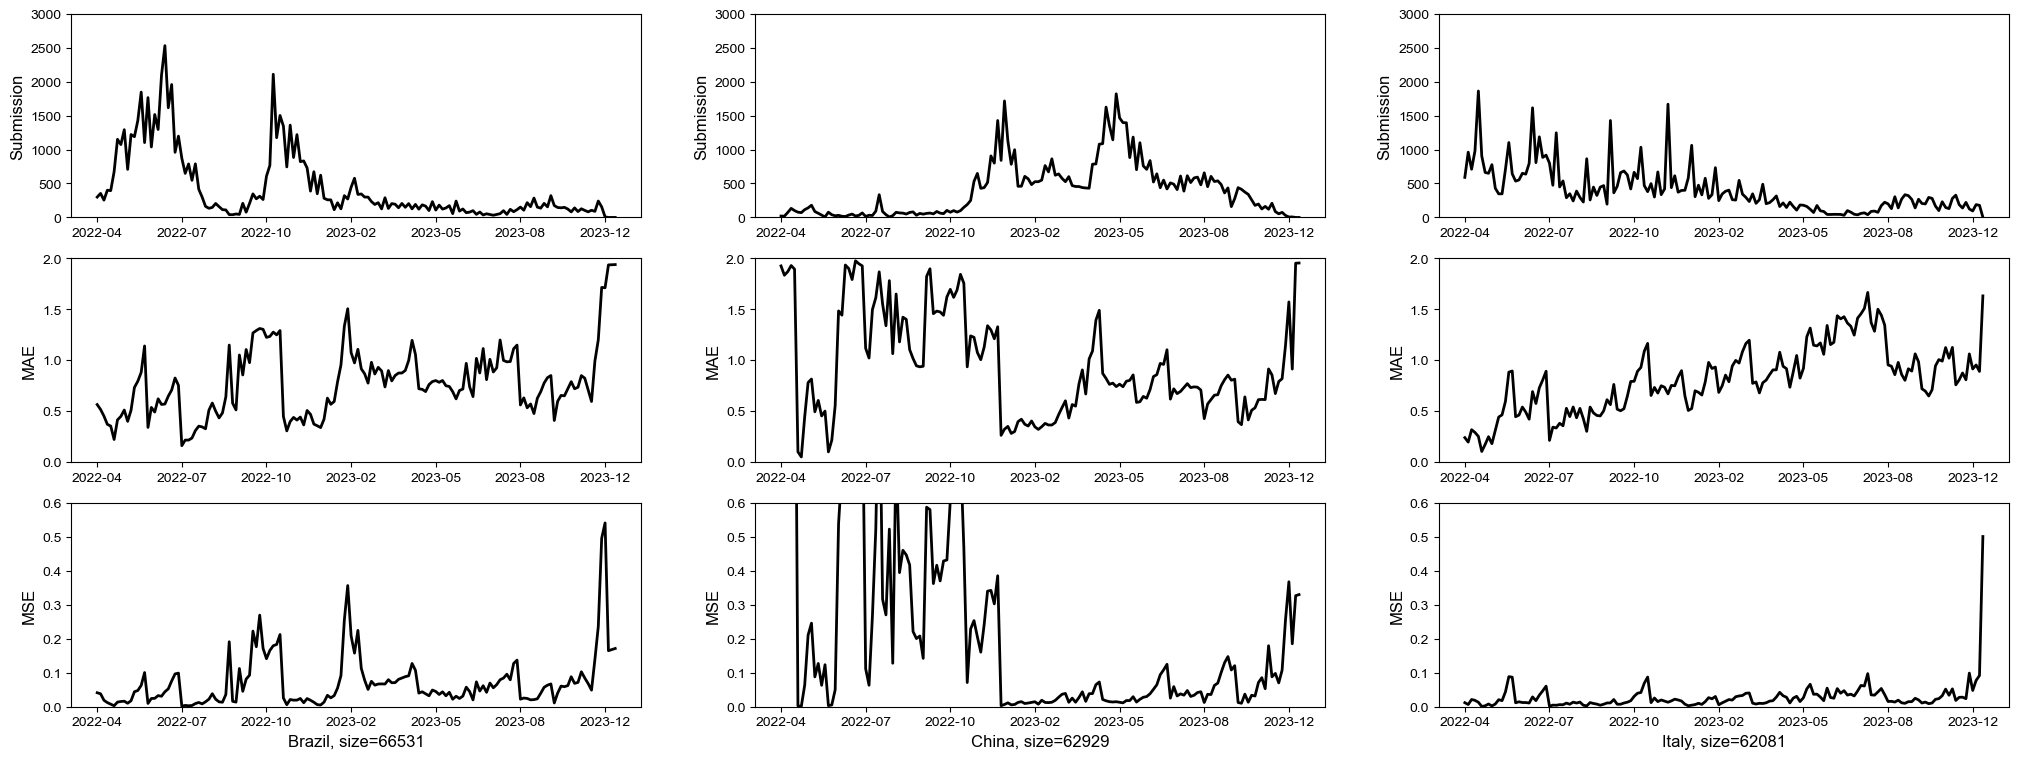

In [318]:
# country1 = ['UnitedKingdom', 'Japan', 'Germany']
country1 = ['Brazil', 'China', 'Italy']
# country1 = ['Denmark', 'Austria', 'SouthKorea', 'Australia']
# country1 = ['Spain', 'Israel', 'Sweden']

country_index1 = []
for i in range(len(country1)):
    country_index1.append(country.index(country1[i]))

plt.figure(figsize=(25, 9))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

datetime_plot = []
string_plot = []
for i in range(n-m):
        if i % 25 == 0:
            datetime_plot.append(time[m+i])
            string_plot.append(time[m+i].strftime('%Y-%m'))

for i in range(len(country_index1)):
    plt.subplot(3,3,i+1)
    plt.plot(time[m:n], counts[m:n, country_index1[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,3000)
    plt.subplot(3,3,i+4)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index1[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('MAE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,2)
    plt.subplot(3,3,i+7)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[2][m:n,country_index1[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('MSE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,0.6)
    plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/104851304.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)


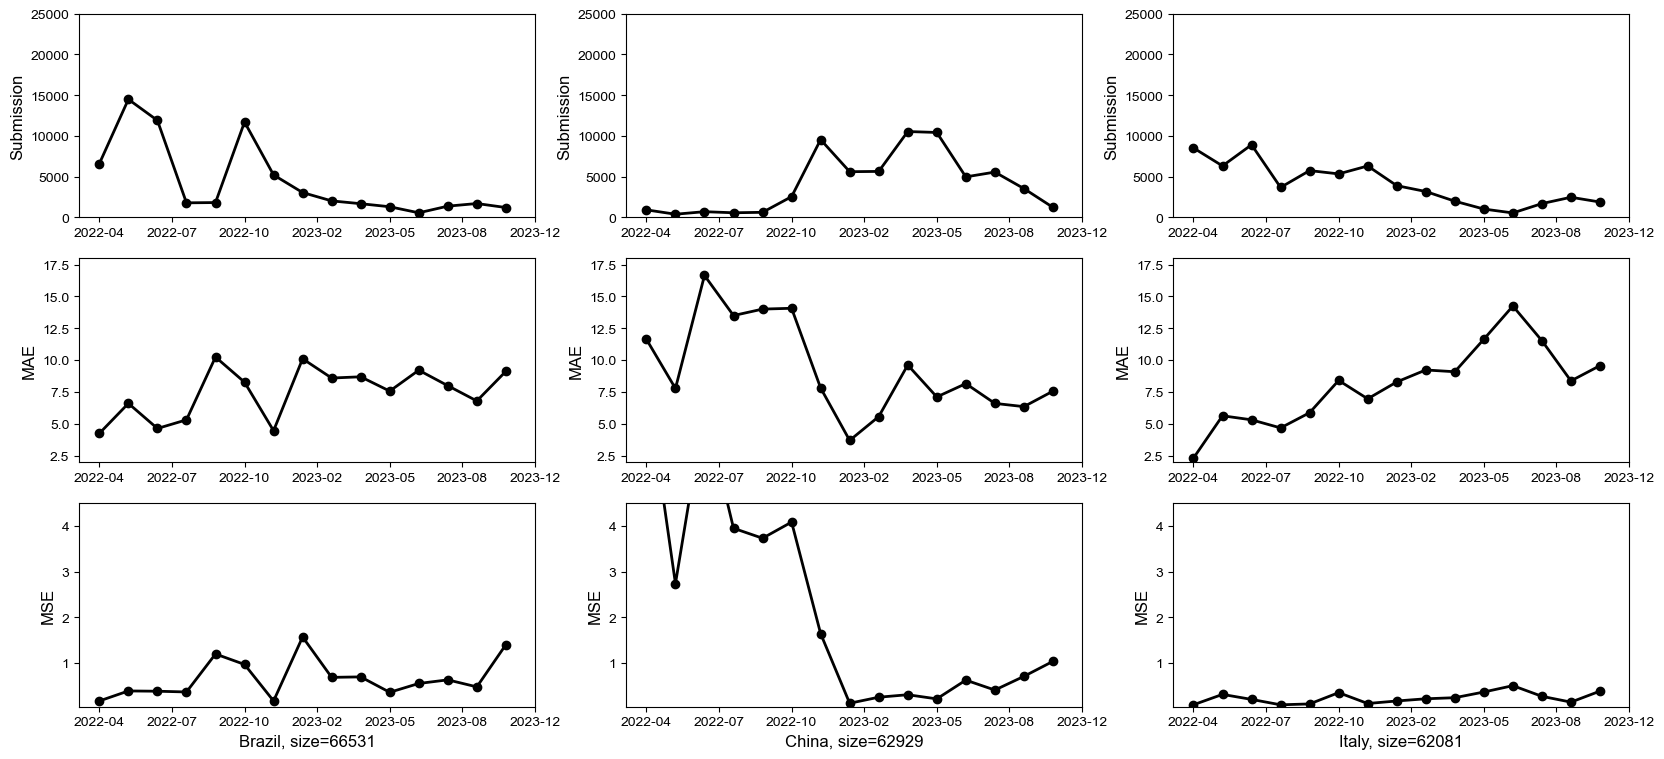

In [319]:
## 10bin for a group
plt.figure(figsize=(20, 9))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

time_plot = []
counts_plot = np.zeros((3, 15))
MAE_plot = np.zeros((3, 15))
MSE_plot = np.zeros((3, 15))
for i in range(15):
    time_plot.append(time[m+10*i])
    
for i in range(len(country_index1)):
    for j in range(15):
        counts_plot[i, j] = counts[m+10*j:m+10*(j+1), country_index1[i], :].sum(-1).sum(0)
        MAE_plot[i,j] = loss_cal_over_time(forecast_AE)[1][m+10*j:m+10*(j+1),country_index1[i]].sum()
        MSE_plot[i, j] = loss_cal_over_time(forecast_AE)[2][m+10*j:m+10*(j+1),country_index1[i]].sum()

    plt.subplot(3,3,i+1)
    plt.plot(time_plot, counts_plot[i,:], color = 'black', lw=2, zorder=-9)
    plt.scatter(time_plot, counts_plot[i,:], color = 'black')
    plt.ylabel('Submission', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,25000)

    plt.subplot(3,3,i+4)
    plt.plot(time_plot, MAE_plot[i,:], color = 'black', lw=2, zorder=-9)
    plt.scatter(time_plot, MAE_plot[i,:], color = 'black')
    plt.ylabel('MAE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(2,18)

    plt.subplot(3,3,i+7)
    plt.plot(time_plot, MSE_plot[i,:], color = 'black', lw=2, zorder=-9)
    plt.scatter(time_plot, MSE_plot[i,:], color = 'black')
    plt.ylabel('MSE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0.05,4.5)
    plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)
plt.show()

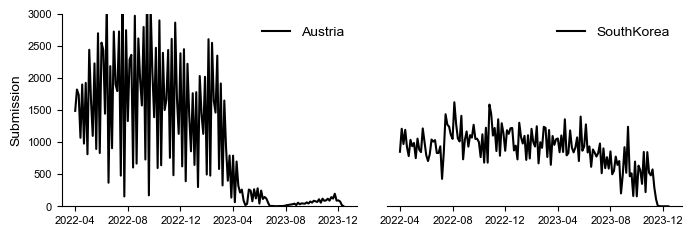

In [48]:
# country1 = ['UnitedKingdom', 'Japan', 'Germany']
# country1 = ['Brazil', 'China', 'Italy']
country1 = ['Austria', 'SouthKorea']
# country1 = ['Israel', 'Sweden']
# country1 = ['Turkey', 'Pakistan']
country_index1 = []
for i in range(len(country1)):
    country_index1.append(country.index(country1[i]))

plt.figure(figsize=(8, 2.5))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

datetime_plot = []
string_plot = []
for i in range(n-m):
        if i % 30 == 0:
            datetime_plot.append(time[m+i])
            string_plot.append(time[m+i].strftime('%Y-%m'))

plt.subplot(1,2,1)
plt.plot(time[m:n], counts[m:n, country_index1[0], :].sum(-1), color = 'black', lw=1.5, zorder=-9, label=country1[0])
plt.ylabel('Submission', fontsize = 10)
plt.xticks(datetime_plot, string_plot,fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylim(0,3000)
ax = plt.gca()#获取边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, loc='upper right',fontsize = 10)
# plt.title('Submissions = 10347; Irregularity = 135',fontsize = 10, pad=10)

plt.subplot(1,2,2)
plt.plot(time[m:n], counts[m:n, country_index1[1], :].sum(-1), color = 'black', lw=1.5, zorder=-9, label=country1[1])
plt.xticks(datetime_plot, string_plot,fontsize = 8)
plt.yticks([],fontsize = 8)
plt.ylim(0,3000)
ax = plt.gca()#获取边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(frameon=False, loc='upper right',fontsize = 10)
# plt.title('Submissions = 2377; Irregularity = 95',fontsize = 10, pad=10)
plt.subplots_adjust(hspace=0.3,wspace=0.1)
plt.show()

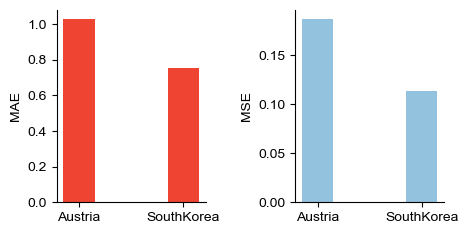

In [49]:
plt.figure(figsize=(5, 2.5))
x_label = (country1[0], country1[1])
MAE = [cal_MAE[country_index1[0]], cal_MAE[country_index1[1]]]
MSE = [cal_MSE[country_index1[0]], cal_MSE[country_index1[1]]]
count = [np.log(counts.sum(-1).sum(0)[country_index1[0]]), np.log(counts.sum(-1).sum(0)[country_index1[1]])]
std = [np.std((counts[:,country_index1[0],:].sum(-1)/counts[:,country_index1[0],:].sum()).tolist()), np.std((counts[:,country_index1[1],:].sum(-1)/counts[:,country_index1[1],:].sum()).tolist())]

bar_width = 0.3

plt.subplot(1,2,1)
plt.bar(x_label, height=MAE, width=bar_width,color = '#EE4431')
plt.ylabel('MAE', fontsize = 10)
plt.xticks(fontsize = 10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(1,2,2)
plt.bar(x_label, height=MSE, width=bar_width,color = '#92C2DD')
plt.ylabel('MSE', fontsize = 10)
plt.xticks(fontsize = 10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.3,wspace=0.6)

In [52]:
print((MAE[0] - MAE[1])/MAE[1])
print((MSE[0] - MSE[1])/MSE[1])
print(MAE[0], MAE[1])
print(MSE[0], MSE[1])

tensor(0.3628)
tensor(0.6419)
tensor(1.0276) tensor(0.7541)
tensor(0.1871) tensor(0.1140)


### Relationship between submission and regularity and loss for countries at the same log(SUBMISSION) level

In [381]:
counts = torch.load('./data/Omicron_experimental_data_new.pkl')['counts']
forecast_AE = torch.load('./10phase_AE.pkl', map_location=torch.device('cpu')).data.cpu()[:counts.shape[0],:,:]

true = counts + 1e-20
count = true.sum(-1, True)
true_probs = true / count

def loss_cal(model): 
    pred = model
    # error = (pred - true_probs) * count**0.5  # scaled by Poisson stddev
    error = pred - true_probs 
    mae = error.abs().mean(0)  # average over time
    mse = error.square().mean(0)  # average over time

    return error, mae, mse

In [382]:
cal_count = np.log(counts.sum(-1).sum(0))
cal_MAE = loss_cal(forecast_AE)[1].sum(-1)
cal_MSE = loss_cal(forecast_AE)[2].sum(-1)

In [383]:
country = torch.load('./data/Omicron_experimental_data_new.pkl')['locations']
country_index_6 = []
country_index_8 = []
country_index_10 = []
for i in range(len(country)):
    if cal_count[i] > 5.9 and cal_count[i] < 6.1:
        country_index_6.append(i)
    elif cal_count[i] > 7.9 and cal_count[i] < 8.1:
        country_index_8.append(i)
    elif cal_count[i] > 9.9 and cal_count[i] < 10.1:
        country_index_10.append(i)

In [384]:
def loss_cal_over_time(model): 
    pred = model
    error = pred - true_probs 
    mae = error.abs().sum(-1)
    mse = error.square().sum(-1)
    return error, mae, mse

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/1477909861.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)


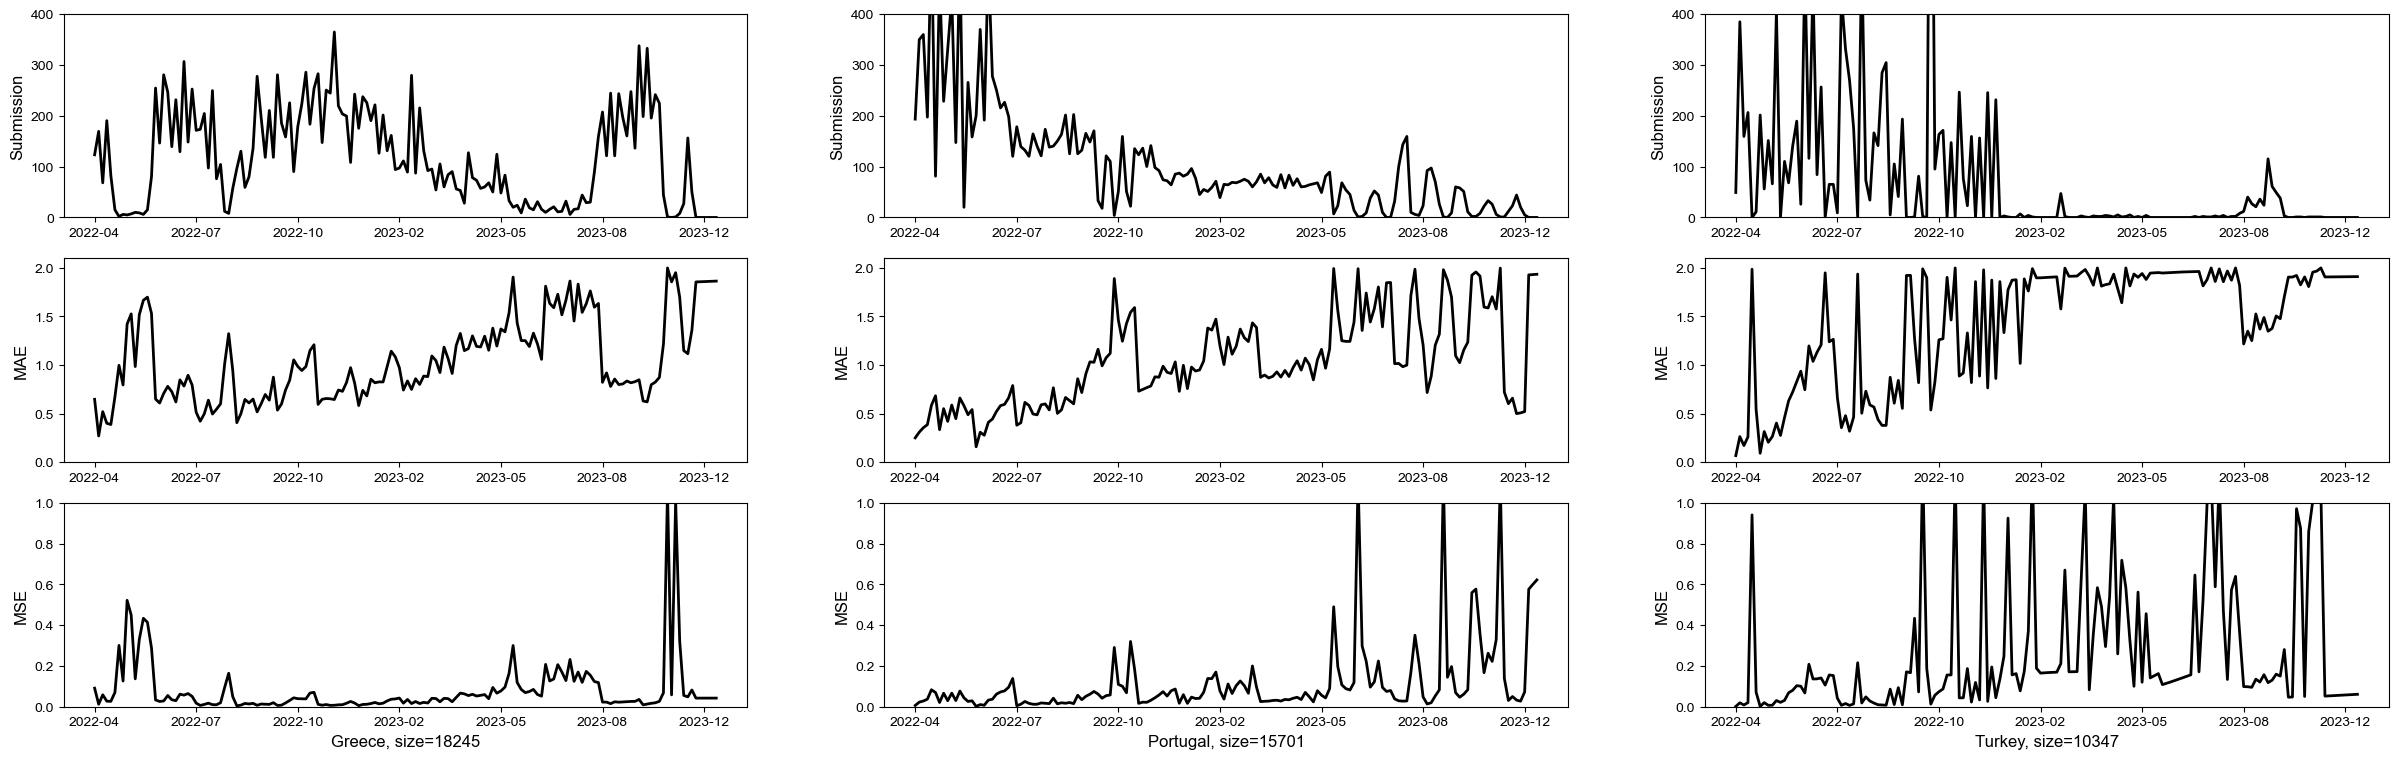

In [394]:
plt.figure(figsize=(30, 9))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

datetime_plot = []
string_plot = []
for i in range(n-m):
        if i % 25 == 0:
            datetime_plot.append(time[m+i])
            string_plot.append(time[m+i].strftime('%Y-%m'))

country_index1 = country_index_10
for i in range(len(country_index1)):
    plt.subplot(3,3,i+1)
    plt.plot(time[m:n], counts[m:n, country_index1[i], :].sum(-1), color = 'black', lw=2, zorder=-9)
    plt.ylabel('Submission', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,400)
    plt.subplot(3,3,i+4)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[1][m:n,country_index1[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('MAE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,2.1)
    plt.subplot(3,3,i+7)
    plt.plot(time[m:n], loss_cal_over_time(forecast_AE)[2][m:n,country_index1[i]], color = 'black', lw=2, zorder=-9)
    plt.ylabel('MSE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,1)
    plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)
plt.show()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_10863/616918878.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)


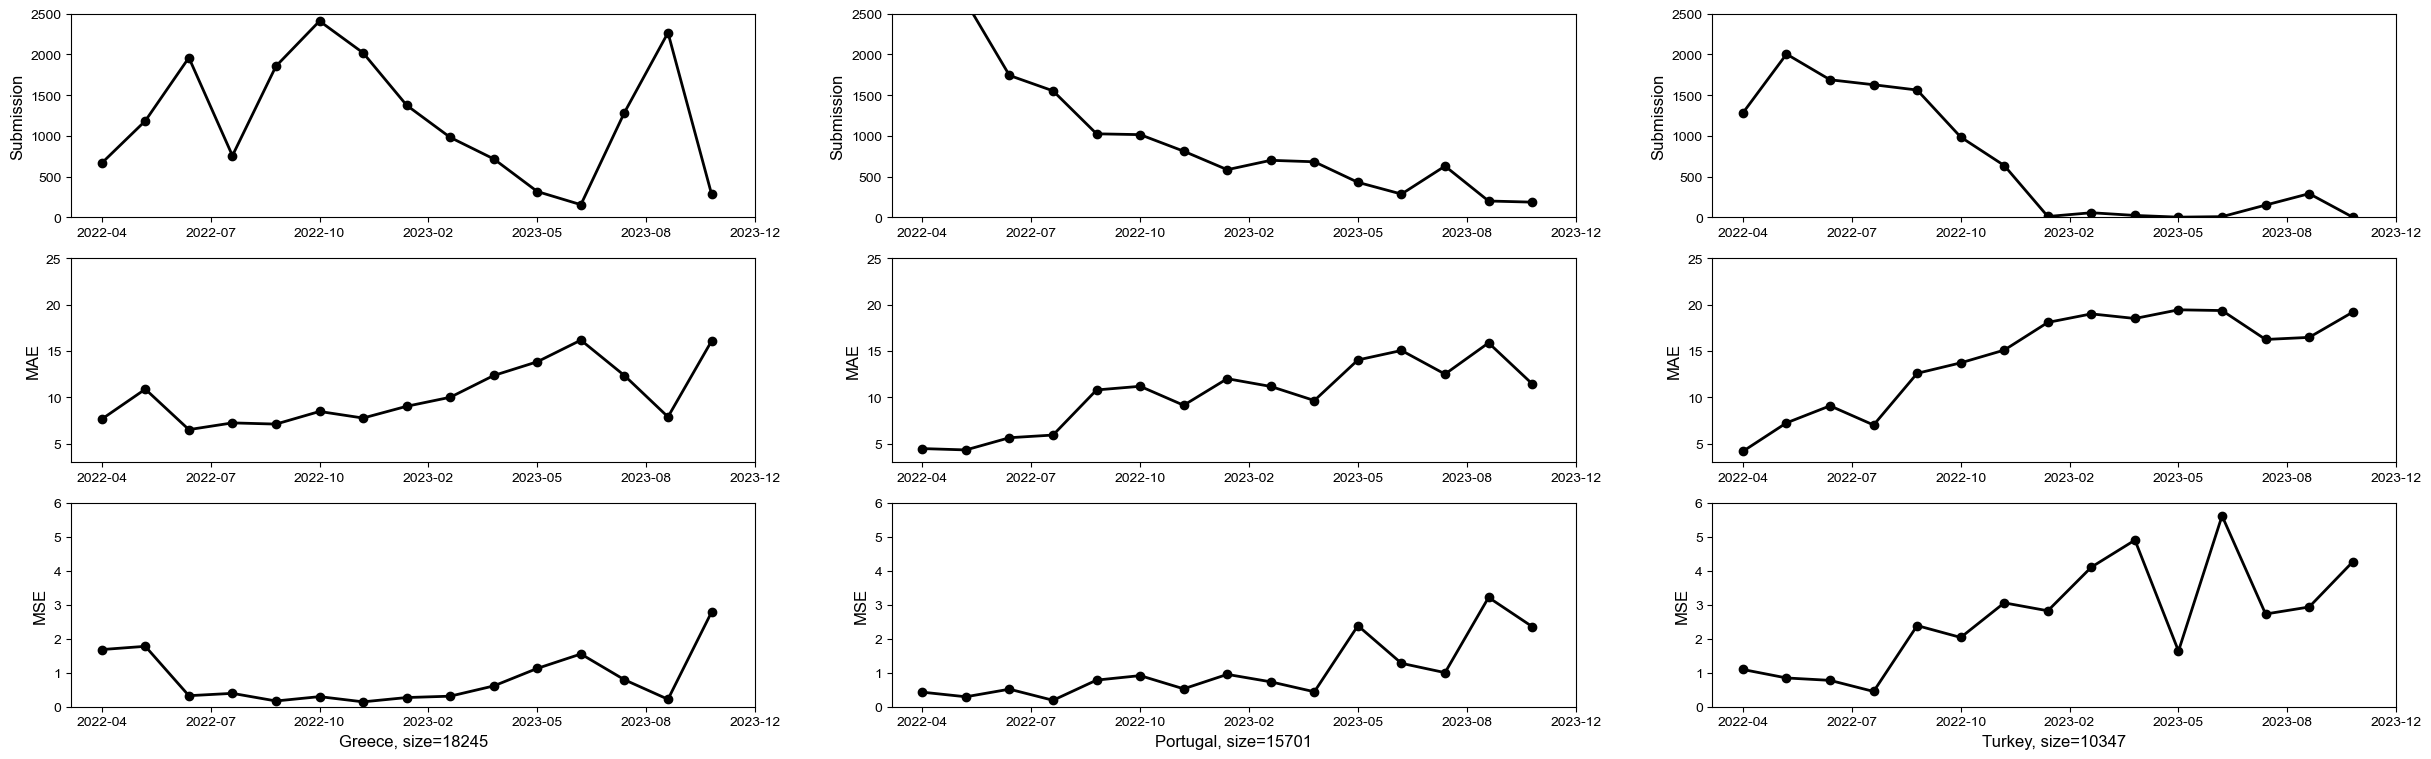

In [399]:
## 10bin for a group
plt.figure(figsize=(30, 9))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 41, 195

time_plot = []
counts_plot = np.zeros((6, 15))
MAE_plot = np.zeros((6, 15))
MSE_plot = np.zeros((6, 15))
for i in range(15):
    time_plot.append(time[m+10*i])
    
for i in range(len(country_index1)):
    for j in range(15):
        counts_plot[i, j] = counts[m+10*j:m+10*(j+1), country_index1[i], :].sum(-1).sum(0)
        MAE_plot[i,j] = loss_cal_over_time(forecast_AE)[1][m+10*j:m+10*(j+1),country_index1[i]].sum()
        MSE_plot[i, j] = loss_cal_over_time(forecast_AE)[2][m+10*j:m+10*(j+1),country_index1[i]].sum()

    plt.subplot(3,3,i+1)
    plt.plot(time_plot, counts_plot[i,:], color = 'black', lw=2, zorder=-9)
    plt.scatter(time_plot, counts_plot[i,:], color = 'black')
    plt.ylabel('Submission', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,2500)

    plt.subplot(3,3,i+4)
    plt.plot(time_plot, MAE_plot[i,:], color = 'black', lw=2, zorder=-9)
    plt.scatter(time_plot, MAE_plot[i,:], color = 'black')
    plt.ylabel('MAE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(3,25)

    plt.subplot(3,3,i+7)
    plt.plot(time_plot, MSE_plot[i,:], color = 'black', lw=2, zorder=-9)
    plt.scatter(time_plot, MSE_plot[i,:], color = 'black')
    plt.ylabel('MSE', fontsize = 12)
    plt.xticks(datetime_plot, string_plot)
    plt.ylim(0,6)
    plt.xlabel(country[country_index1[i]]+', size='+str(np.int(counts[m:n, country_index1[i], :].sum())), fontsize = 12)
plt.show()